## 0.UPLOAD LIBRARIES

In [1]:
import os
import pandas as pd
import tqdm
import gc
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import pickle

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
import sys
sys.path.append("/kaggle/input/credit-pipeline-script")

from credit_pipeline import CreditScoringPipeline

## 1.DATA PREPARATION

In [1]:
def read_parquet_files(path_to_dataset, start_from=0, num_parts_to_read=1, columns=None):
    dataset_paths = sorted([
        os.path.join(path_to_dataset, f)
        for f in os.listdir(path_to_dataset)
        if f.endswith('.pq')
    ])
    chunks = dataset_paths[start_from: start_from + num_parts_to_read]
    res = []
    for path in chunks:
        df = pd.read_parquet(path, columns=columns)
        res.append(df)
        #далее возвращаем df из объединенных партиций
    return pd.concat(res).reset_index(drop=True)

def process_and_aggregate_chunk(df):
    drop_cols = ['rn']
    for col in drop_cols:
        if col in df.columns:
            df = df.drop(columns=col)

    cat_cols = [col for col in df.columns if col != 'id' and df[col].nunique() <= 50]
    
    dummies = pd.get_dummies(df[cat_cols], columns=cat_cols, dtype='uint8')
    #финальный df из id и ohe признаков
    df = pd.concat([df[['id']], dummies], axis=1)
    #"схлопываем" по id
    df_agg = df.groupby('id').sum().reset_index()
    return df_agg

def prepare_data_in_batches(path_to_dataset, num_parts_total=12, batch_size=1):
    all_aggregated_chunks = []

    for step in tqdm.tqdm(range(0, num_parts_total, batch_size), desc="Processing batches"):
        df = read_parquet_files(path_to_dataset, start_from=step, num_parts_to_read=batch_size)
        df_agg = process_and_aggregate_chunk(df)
        all_aggregated_chunks.append(df_agg)
        #чистим память после каждого батча, так как работаем в Kaggle
        del df, df_agg
        gc.collect()

    final_data = pd.concat(all_aggregated_chunks).groupby('id').sum().reset_index()
    return final_data

In [2]:
final_df = prepare_data_in_batches(
    path_to_dataset='/kaggle/input/train-data/',
    num_parts_total=12,
    batch_size=1
)

Processing batches: 100%|██████████| 12/12 [03:28<00:00, 17.40s/it]


In [4]:
final_df.head()

,id,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,pre_since_opened_8,...,pre_loans530_8,pre_loans530_9,pre_loans_total_overdue_1,pre_loans_max_overdue_sum_0,pre_loans3060_0,pre_loans3060_3,pre_loans3060_4,pre_loans6090_0,pre_loans5_10,pre_loans530_17
0,0,0,1,1,1,1,2,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,1,0,0,0,0,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,3,1,0,2,1,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Columns: 420 entries, id to pre_loans530_17
dtypes: float64(27), int64(1), uint8(392)
memory usage: 1.7 GB


In [7]:
target_df = pd.read_csv('/kaggle/input/train-data/train_target.csv')
target_df.head()

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [9]:
merged_df = pd.merge(target_df, final_df, on='id', how='inner')

In [10]:
print(merged_df.shape)

(3000000, 421)


In [12]:
merged_df.to_parquet("/kaggle/working/merged_df.parquet", index=False)

## 2.MODELING

In [3]:
merged_df = pd.read_parquet("/kaggle/input/train-data/merged_df.parquet")
merged_df.head()

,id,flag,pre_since_opened_0,pre_since_opened_1,pre_since_opened_2,pre_since_opened_3,pre_since_opened_4,pre_since_opened_5,pre_since_opened_6,pre_since_opened_7,...,pre_loans530_8,pre_loans530_9,pre_loans_total_overdue_1,pre_loans_max_overdue_sum_0,pre_loans3060_0,pre_loans3060_3,pre_loans3060_4,pre_loans6090_0,pre_loans5_10,pre_loans530_17
0,0,0,0,1,1,1,1,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,0,0,1,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,0,3,1,0,2,1,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
X = merged_df.drop(columns=['id', 'flag'])
y = merged_df['flag']

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
#catboost

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50
)

model.fit(X_train, y_train, eval_set=(X_val, y_val))

y_pred_proba = model.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"catboost roc-auc: {roc_auc:.4f}")

0:	test: 0.5202302	best: 0.5202302 (0)	total: 1.15s	remaining: 19m 12s
100:	test: 0.7477001	best: 0.7477001 (100)	total: 2m 18s	remaining: 20m 31s
200:	test: 0.7536812	best: 0.7536812 (200)	total: 4m 28s	remaining: 17m 47s
300:	test: 0.7557422	best: 0.7557422 (300)	total: 6m 26s	remaining: 14m 58s
400:	test: 0.7571647	best: 0.7571647 (400)	total: 8m 27s	remaining: 12m 37s
500:	test: 0.7580397	best: 0.7580397 (500)	total: 10m 27s	remaining: 10m 24s
600:	test: 0.7589005	best: 0.7589005 (600)	total: 12m 24s	remaining: 8m 14s
700:	test: 0.7593545	best: 0.7593545 (700)	total: 14m 21s	remaining: 6m 7s
800:	test: 0.7598461	best: 0.7598461 (800)	total: 16m 16s	remaining: 4m 2s
900:	test: 0.7601893	best: 0.7601893 (900)	total: 18m 13s	remaining: 2m
999:	test: 0.7606238	best: 0.7606238 (999)	total: 20m 13s	remaining: 0us

bestTest = 0.760623814
bestIteration = 999

\catboost roc-auc: 0.7606


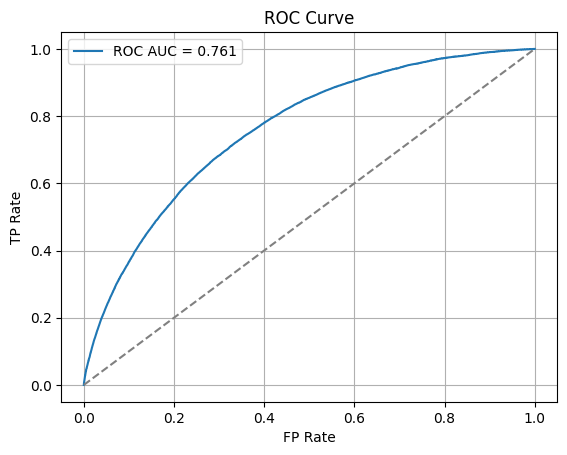

In [7]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('FP Rate')
plt.ylabel('TP Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [8]:
importances = model.get_feature_importance(prettified=True)
importances.head(10)

,Feature Id,Importances
0,pre_util_3,6.083341
1,is_zero_loans530_0,4.674974
2,enc_loans_credit_type_0,4.485707
3,pre_util_6,4.116452
4,pre_till_pclose_10,3.917071
5,is_zero_loans3060_0,2.962321
6,is_zero_loans6090_0,2.602673
7,enc_paym_0_1,2.517909
8,pre_loans_credit_limit_2,2.488687
9,enc_paym_3_0,2.440176


Все признаки работают совместно, давая модели объемное представление о профиле заемщика. pre_util измеряет текущую долговую нагрузку, is_zero_loans отражает надежность платежной истории, enc_loans_credit_type задает базовый уровень риска по типу задолженности, а pre_till_pclose учитывает временной горизонт риска. Каждая из этих фич по-своему влияет на вероятность дефолта, и их комбинация помогает модели кредитного скоринга точнее и справедливее отличать низкорискованных клиентов от тех, кто с большей вероятностью столкнется с проблемами выплаты долга.

In [9]:
print(y.value_counts(normalize=True))

flag
0    0.964519
1    0.035481
Name: proportion, dtype: float64


In [10]:
#lgbm

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
    'verbose': -1
}

model = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'val'],
    callbacks=[
        lgb.early_stopping(50),
        lgb.log_evaluation(period=100)
    ]
)

y_pred_proba = model.predict(X_val)
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"lgbm roc-auc: {roc_auc:.4f}")

Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.764058	val's auc: 0.753576
[200]	train's auc: 0.77622	val's auc: 0.756862
[300]	train's auc: 0.785559	val's auc: 0.757821
[400]	train's auc: 0.793801	val's auc: 0.758115
Early stopping, best iteration is:
[390]	train's auc: 0.793008	val's auc: 0.758217
lgbm roc-auc: 0.7582


In [11]:
#xgboost

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.1,
    'max_depth': 6,
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),  # дисбаланс
    'seed': 42,
    'verbosity': 1
}

watchlist = [(dtrain, 'train'), (dval, 'eval')]
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=100
)

y_pred_proba = model.predict(dval)
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f"xgboost roc-auc: {roc_auc:.4f}")

[0]	train-auc:0.69704	eval-auc:0.69274
[100]	train-auc:0.77342	eval-auc:0.75537
[200]	train-auc:0.78864	eval-auc:0.75892
[289]	train-auc:0.79750	eval-auc:0.75932
xgboost roc-auc: 0.7593


In [12]:
# лучший результат по метрике roc-auc у catboost - 0.7606

## 3.FINAL PIPELINE AND PREDICTION

In [5]:
pipeline = CreditScoringPipeline()
pipeline.fit(X, y)

CreditScoringPipeline(model_params={'depth': 6, 'early_stopping_rounds': 50,
                                    'eval_metric': 'AUC', 'iterations': 1000,
                                    'learning_rate': 0.1, 'random_seed': 42,
                                    'verbose': False})

In [6]:
with open("credit_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

In [7]:
y_pred = pipeline.predict(X)
submission = pd.DataFrame({
    "id": merged_df["id"],
    "prediction": y_pred
})
submission.to_csv("test_predictions.csv", index=False)

In [8]:
# preds check
# threshold 0.07

df_preds = pd.read_csv("test_predictions.csv")
df_preds["prediction"].value_counts(normalize=True)

prediction
0    0.876261
1    0.123739
Name: proportion, dtype: float64

In [9]:
# 12.3% положительных предсказаний при threshold 0.07 показывает чуть больше
# чувствительности; истинная доля около 3.5%, как я указывал выше;
# с учетом того, что основная масса вероятности класса 1 в районе 0.00-0.05 - получаем
# неплохой результат и компромисс между recall и precision (то есть для данного кейса
# лучше немного перестраховаться, чем пропустить рискового клиента)

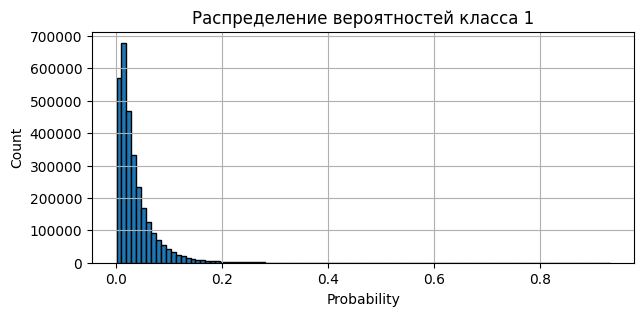

In [10]:
probas = pipeline.predict_proba(X)[:, 1]
plt.figure(figsize=(7, 3))
plt.hist(probas, bins=100, edgecolor='black')
plt.title("Распределение вероятностей класса 1")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.grid(True)
plt.show()